#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose

#Константы
MAX_LAG = 7
ROLLING_MEAN_SIZE = 3
RANDOM_STATE = 12345

In [2]:
def describe_df(DataFrame):

    binary_feats = [col for col in DataFrame.columns if DataFrame[col].nunique() <= 2]
    categorical_feats = [col for col in DataFrame.columns if DataFrame[col].dtype == 'object' and col not in binary_feats]
    continuous_feats = [col for col in DataFrame.columns if DataFrame[col].dtype != 'object' and col not in binary_feats]

    print('Бинарные переменные:', binary_feats)
    print('Категориальные переменные:', categorical_feats)
    print('Количественные переменные:', continuous_feats, '\n')

    print('Количество столбцов:', DataFrame.shape[1])
    print('Количество строк:', DataFrame.shape[0], '\n')

    print('Пропуски:\n')
    print(DataFrame.isna().sum(),'\n')
    print('Дубликаты:', DataFrame.duplicated().sum(),'\n')
    print(f'\nТипы данных: \n{DataFrame.dtypes}')

    print('Описание:\n')
    display(DataFrame.describe())
    print()

    print('Dataframe начало\n')
    display(DataFrame.head())
    print()
    print('Dataframe конец\n')
    display(DataFrame.tail())

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.name = 'taxi'

In [4]:
describe_df(taxi)

Бинарные переменные: []
Категориальные переменные: []
Количественные переменные: ['num_orders'] 

Количество столбцов: 1
Количество строк: 26496 

Пропуски:

num_orders    0
dtype: int64 

Дубликаты: 26415 


Типы данных: 
num_orders    int64
dtype: object
Описание:



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Dataframe начало



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Dataframe конец



,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
taxi[taxi['num_orders'] == 119]

,num_orders
datetime,
2018-08-13 02:20:00,119
2018-08-27 02:10:00,119


In [6]:
taxi.index.is_monotonic_increasing

True

Данные расположены последовательно на временном отрезке.

In [7]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


В количестве заказов аномалий не обнаружено, отрицательных значений нет, минимум заказов-0, максимум-119.

В датасете 2 колонки, 26496 наблюдений, пропусков и явных дубликатов не обнаружено. 

Заранее сделали столбец Datetime столбцом индексом.

Данные представленны за период с 1 марта 2018 года по 31 августа 2018 года с итервалом - 10 мин.

## Анализ

In [8]:
taxi_hourly = taxi.resample('H').sum()
taxi_hourly

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


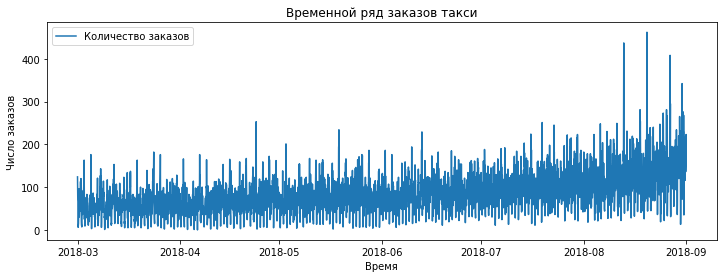

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(taxi_hourly.index, taxi_hourly['num_orders'], label='Количество заказов')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.title('Временной ряд заказов такси')
plt.legend()
plt.show()

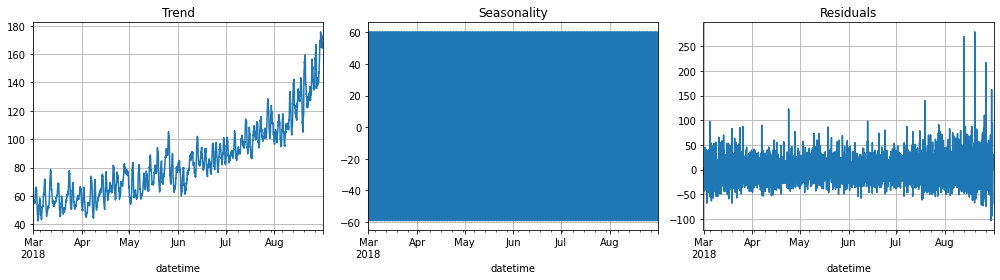

In [10]:
decomposed_H = seasonal_decompose(taxi_hourly)

plt.figure(figsize=(14, 4))
plt.subplot(131)
decomposed_H.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(132)
decomposed_H.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.subplot(133)
decomposed_H.resid.plot(ax=plt.gca(), grid=True)
plt.title('Residuals')

plt.tight_layout()

По тренду видим увеличение спроса на такси с начала марта до конца августа, сезонность определить невозможно. На графике остатков видны колебания.

Чтобы лучше проанализировать временной ряд, сделаем ресемплирование по одному дню.

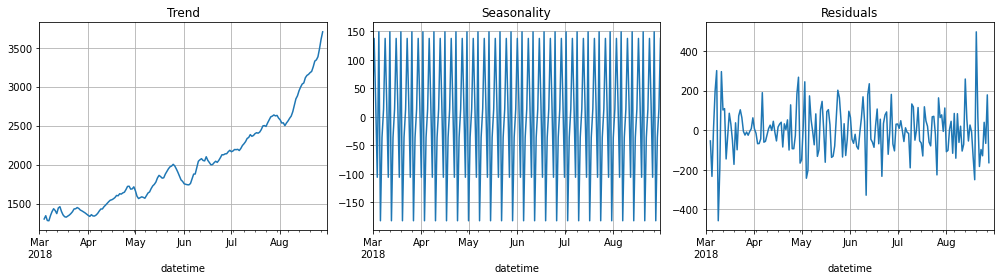

In [11]:
taxi_daily = taxi.resample('1D').sum()
decomposed_D = seasonal_decompose(taxi_daily)

plt.figure(figsize=(14, 4))
plt.subplot(131)
decomposed_D.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(132)
decomposed_D.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.subplot(133)
decomposed_D.resid.plot(ax=plt.gca(), grid=True)
plt.title('Residuals')

plt.tight_layout()

Здесь аналогично наблюдается увеличение спроса с начала марта по конец августа, сезонность сложно оценить, остатки колеблются еще больше.

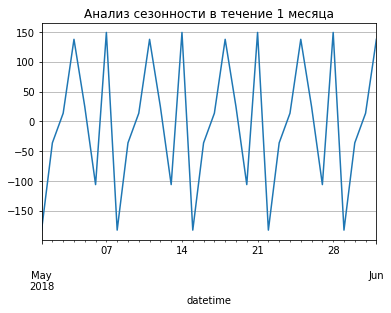

In [12]:
decomposed_D.seasonal['2018-05-01':'2018-06-01'].plot(ax=plt.gca(), grid=True)
plt.title('Анализ сезонности в течение 1 месяца')
plt.show()

Наименьшее количество заказов наблюдается по вторникам и воскресеньям, наибольший-по пятницам и понедельникам.

Рассмотрим также влияние времени суток на количество заказов на основе наблюдений из двух рандомных дней.

Text(0.5, 1.0, 'Понедельник, 21 мая')

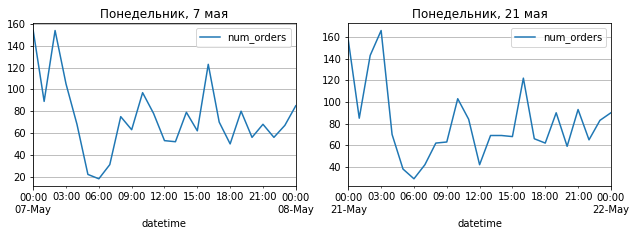

In [13]:
plt.figure(figsize=(16, 3))
plt.subplot(131)
taxi_hourly['2018-05-07 00:00':'2018-05-08 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Понедельник, 7 мая')
plt.subplot(132)
taxi_hourly['2018-05-21 00:00':'2018-05-22 00:00'].plot(ax=plt.gca(), grid=True)
plt.title('Понедельник, 21 мая')

В целом, наблюдаются одинаковые картины: пиковая нагрузка прихожится на 3 часа ночи и 16-17 часов вечера, наименьшее число заказов наблюдается в 6 утра и 12 часов дня.

На количество заказов влияют: месяц, день недели и часы в сутках, поэтому необходимо будет добавить новые признаки.

Мы выяснили, что в летний период спрос на услуги такси в аэропорты растет, также если рассматривать на более мелком временном промежутке, можно прийти к выводу, что такси чаще заказывают по понедельникам и пятницам, реже-по понедельникам и воскресеньям.

В рамках одного дня услугами такси пользуются чаще в 3 часа ночи и в 16-17 часов вечера, реже-в 6 утра и в 12 дня.

## Обучение

In [14]:
taxi = taxi.resample('H').sum()

taxi['month'] = taxi.index.month
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] =taxi.index.hour

taxi['month'] = taxi['month'].astype('category')
taxi['dayofweek'] = taxi['dayofweek'].astype('category')
taxi['hour'] = taxi['hour'].astype('category')
#Добавили переменные месяца, дня и часа.

In [15]:
for lag in range(1, MAX_LAG+1):
    taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag) 
taxi.dropna(inplace=True)
# Добавили значения за предыдущее время

In [16]:
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(ROLLING_MEAN_SIZE).mean()
taxi.dropna(inplace=True)
# Добавили значения скользящего среднего за 3 часа

In [17]:
taxi.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,39.333333
2018-03-01 11:00:00,96,3,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,55.666667
2018-03-01 12:00:00,30,3,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,76.333333
2018-03-01 13:00:00,32,3,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,63.333333
2018-03-01 14:00:00,48,3,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,52.666667


In [18]:
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
pipeline_lr = Pipeline([
    ('lr', LinearRegression())
])

In [21]:
pipeline_rf = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [22]:
pipeline_cat = Pipeline([
    ('cat', CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1,
                                verbose=0, random_state=42, cat_features=['month', 'dayofweek', 'hour']))
])

In [23]:
pipeline_lgb = Pipeline([
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
])

In [24]:
models = {
    'Линейная регрессия': pipeline_lr,
    'Random Forest': pipeline_rf,
    'CatBoost': pipeline_cat,
    'LightGBM': pipeline_lgb
}

In [25]:
for name, model in models.items():

    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

    rmse_scores = np.sqrt(-scores)
    print(f'{name}: RMSE = {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}')

Линейная регрессия: RMSE = 33.49 ± 0.61
Random Forest: RMSE = 25.33 ± 0.51
CatBoost: RMSE = 25.30 ± 0.32
LightGBM: RMSE = 23.57 ± 0.40


## Тестирование

In [26]:
pipeline_lgb.fit(X_train, y_train)
lgb_model = pipeline_lgb.named_steps['lgb']
predictions_lgb = pipeline_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, predictions_lgb))
print(f"RMSE для LightGBM: {rmse_lgb:.2f}")

RMSE для LightGBM: 42.27


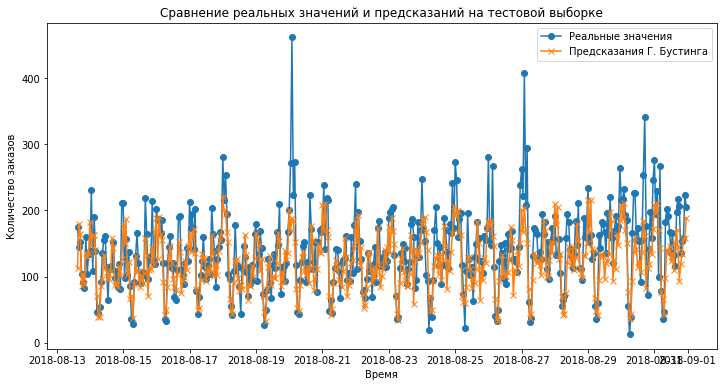

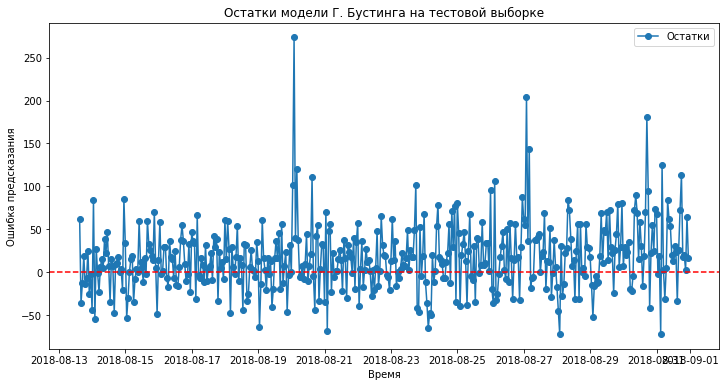

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Реальные значения', marker='o')
plt.plot(y_test.index, predictions_lgb, label='Предсказания Г. Бустинга', marker='x')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Сравнение реальных значений и предсказаний на тестовой выборке')
plt.legend()
plt.show()

residuals = y_test - predictions_lgb
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, label='Остатки', marker='o')
plt.xlabel('Время')
plt.ylabel('Ошибка предсказания')
plt.title('Остатки модели Г. Бустинга на тестовой выборке')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

Анализ данных с 1 марта по 31 августа 2018 года (интервал – 10 минут) показал устойчивый рост спроса на такси: с 700–800 заказов в сутки в марте до 3500–3700 в августе (рост в 5 раз).

Наименьшее число поездок в аэропорт приходится на воскресенье и вторник, наибольшее – на понедельник и пятницу. Пиковый час по понедельникам – 2:00 ночи.

Средние показатели:

Мин. – 0 заказов
Сред. – 14 заказов
Макс. – 119 заказов

Спрос зависит от сезона, дня недели и времени суток.

Было протестировано 5 моделей с разными гиперпараметрами.
Лучшая – CatBoost Regressor:

RMSE (тест) = 42.27
Модель систематически занижает прогнозы, возможна доработка. Однако, в текущем виде соответствует ТЗ.